In [1]:
import numpy as np
import matplotlib.pyplot as plt
from poles_roots.aaa import AAA
from poles_roots._utils import linspace_on_tri, convert_cart_to_complex
from tqdm import tqdm
plt.style.use("/home/jakeb/development/poles-and-roots/notebooks/science.mplstyle")

For now we only consider right triangle of different sizes.

In [2]:
side_length = 1

points = np.array([[0,0], [side_length, 0], [0, side_length]])

def linspace_in_right_triangle(num, side_length):
    tmp = np.linspace(0, side_length, num=int(num**0.5))
    [xx, yy] = np.meshgrid(tmp, tmp)
    mask = xx + yy > side_length
    xx = xx[~mask]
    yy = yy[~mask]
    return xx.ravel(), yy.ravel()

# First for a meromorphic function

\begin{equation}
f(z) = \frac{1}{(z - a)^\alpha},
\end{equation}
where $a$ is drawn from uniform distribution and $\alpha$ is a random integer drawn from $\{1,2,\dots,9\}$.

In [3]:
rng = np.random.default_rng(123456)
in_iterations = []
on_iterations = []
in_pole_error = []
on_pole_error = []
in_approximation_error = []
on_approximation_error = []
order = 1

for _ in tqdm(range(1000)):
    # generate random pole
    re_pole = rng.uniform(0, side_length)
    im_pole = rng.uniform(0, side_length)
    if re_pole + im_pole > side_length:
        re_pole = side_length - re_pole
        im_pole = side_length - im_pole   
    
    pole = re_pole+im_pole*1j
    def f(z):
        return 1/(z-(pole))**order
    
    x, y = linspace_in_right_triangle(1000, side_length)
    Z_in = x+y*1j
    F_in = f(Z_in)
    
    n_actual = x.size
    
    Z = convert_cart_to_complex(linspace_on_tri(points, n_actual))
    F = f(Z)
    
    res_in = AAA(F_in, Z_in)
    res = AAA(F, Z)
    
    in_pole_error.append(np.min(np.abs(res_in.poles - pole)))
    on_pole_error.append(np.min(np.abs(res.poles - pole)))
    

100%|██████████| 1000/1000 [00:00<00:00, 1231.36it/s]


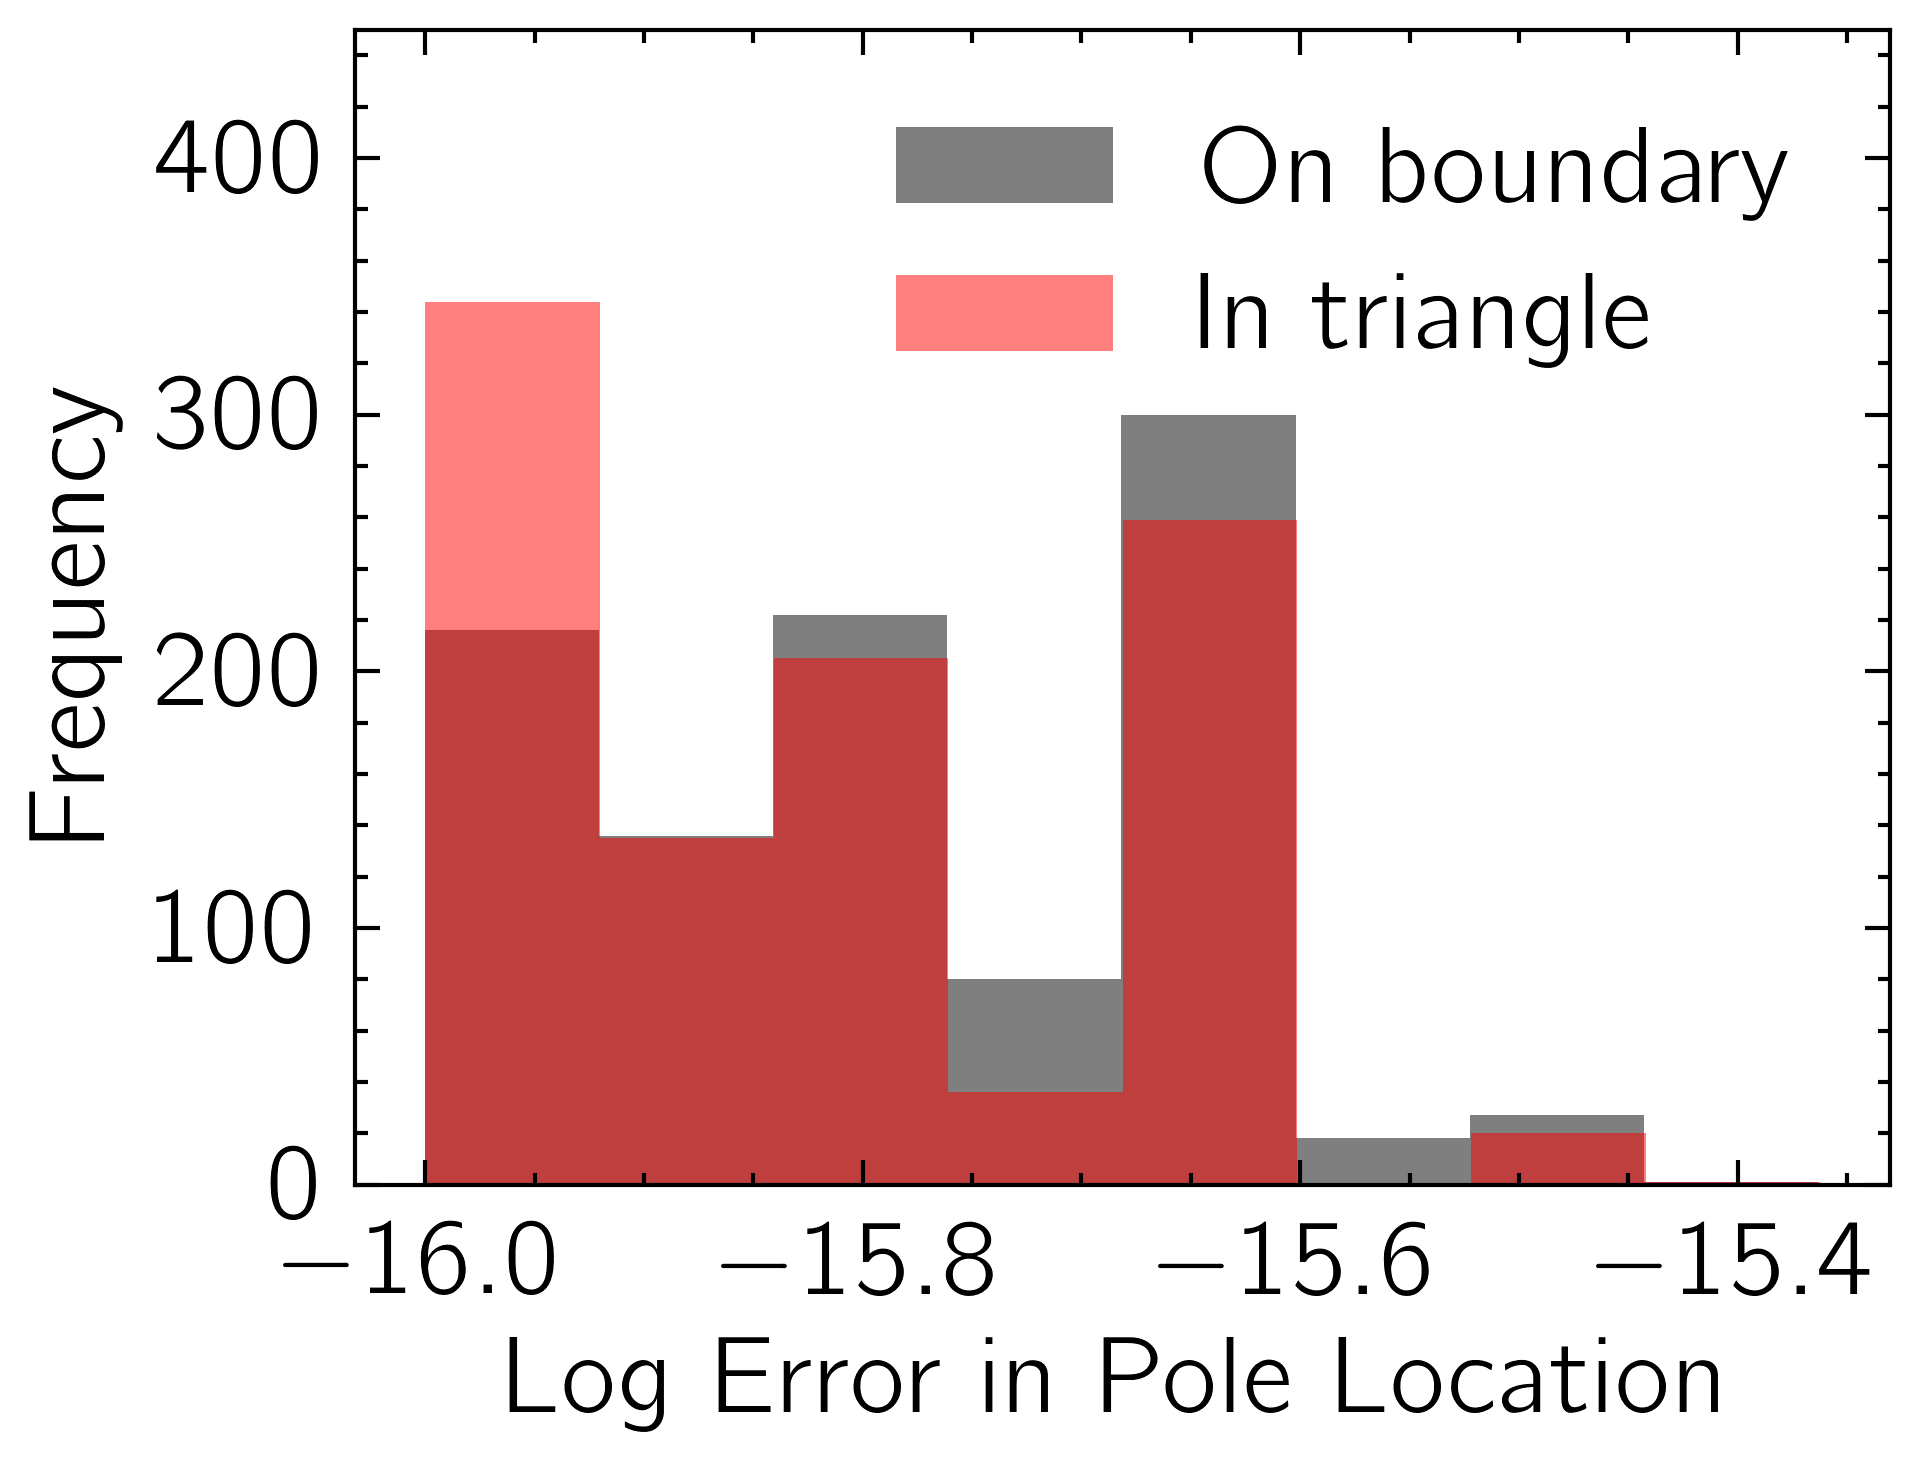

In [4]:
fig, ax = plt.subplots()
ax.hist(np.log10(np.asarray(on_pole_error) + 1e-16), alpha=0.5, label="On boundary", bins=8)
ax.hist(np.log10(np.asarray(in_pole_error) + 1e-16), alpha=0.5, label="In triangle", bins=8)
ax.set_xlabel("Log Error in Pole Location")
ax.set_ylabel("Frequency")
ax.set_ylim([0,450])
ax.legend()
plt.savefig("figures/AAA_sampling.pdf")

# Then for a Holomorphic function

\begin{equation}
f(z) = (z - a)^\alpha,
\end{equation}
where $a$ is drawn from uniform distribution and $\alpha$ is a random integer drawn from $\{1,2,\dots,9\}$.

In [7]:
rng = np.random.default_rng(123456)
in_iterations = []
on_iterations = []
in_pole_error = []
on_pole_error = []
in_approximation_error = []
on_approximation_error = []
orders = [1, 2, 4, 8]

for order in orders:
    in_iterations_tmp = []
    on_iterations_tmp = []
    in_pole_error_tmp = []
    on_pole_error_tmp = []
    in_approximation_error_tmp = []
    on_approximation_error_tmp = []
    for _ in tqdm(range(1000)):
        # generate random zero
        re_pole = rng.uniform(0, side_length)
        im_pole = rng.uniform(0, side_length)
        if re_pole + im_pole > side_length:
            re_pole = side_length - re_pole
            im_pole = side_length - im_pole   
        
        zero = re_pole+im_pole*1j
        def f(z):
            return (z-(zero))**order
        
        x, y = linspace_in_right_triangle(1000, side_length)
        Z_in = x+y*1j
        F_in = f(Z_in)
        
        n_actual = x.size
        
        Z = convert_cart_to_complex(linspace_on_tri(points, n_actual))
        F = f(Z)
        
        res_in = AAA(F_in, Z_in)
        res = AAA(F, Z)
        
        on_iterations_tmp.append(res.weights.size)
        in_iterations_tmp.append(res_in.weights.size)
        in_pole_error_tmp.append(np.min(np.abs(res_in.roots - zero)))
        on_pole_error_tmp.append(np.min(np.abs(res.roots - zero)))
        
        # generate random points to sample the approximation at
        re_sample = rng.uniform(0, side_length, size=10)
        im_sample = rng.uniform(0, side_length, size=10)
        mask = re_sample + im_sample > side_length
        re_sample[mask] = side_length - re_sample[mask]
        im_sample[mask] = side_length - im_sample[mask]
        sample = re_sample + im_sample*1j
        
        in_approximation_error_tmp.append(np.max(np.abs(f(sample) - res_in(sample))))
        on_approximation_error_tmp.append(np.max(np.abs(f(sample) - res(sample))))
    in_iterations.append(in_iterations_tmp)
    on_iterations.append(on_iterations_tmp)
    in_pole_error.append(in_pole_error_tmp)
    on_pole_error.append(on_pole_error_tmp)
    in_approximation_error.append(in_approximation_error_tmp)
    on_approximation_error.append(on_approximation_error_tmp)

100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


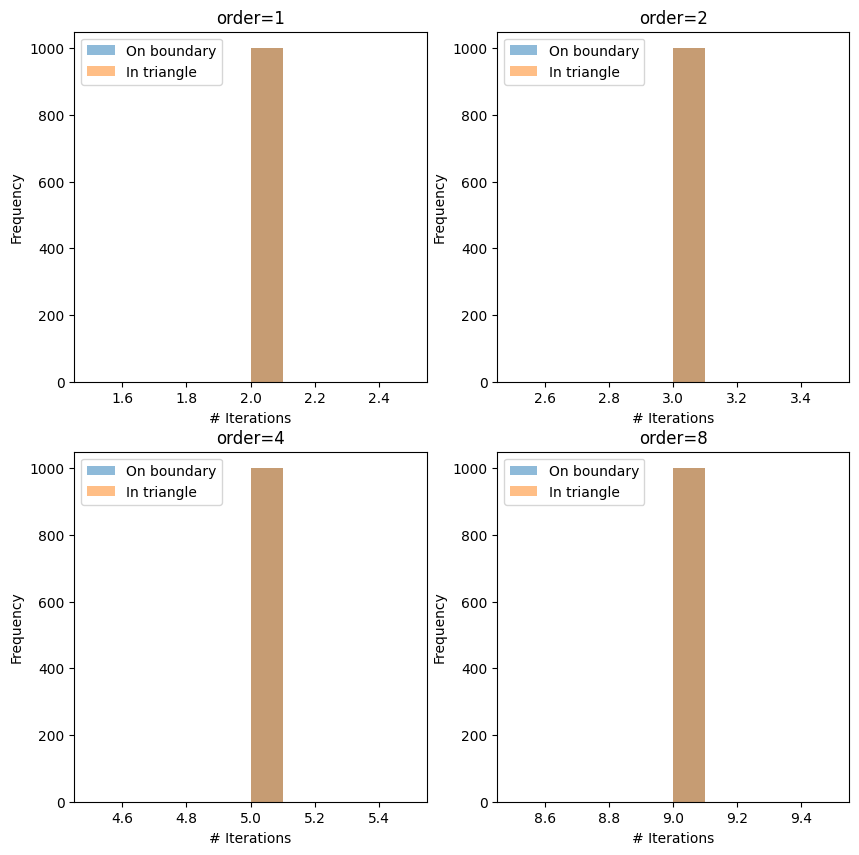

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(on_iterations[i], alpha=0.5, label="On boundary")
    ax.hist(in_iterations[i], alpha=0.5, label="In triangle")
    ax.set_xlabel("# Iterations")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()

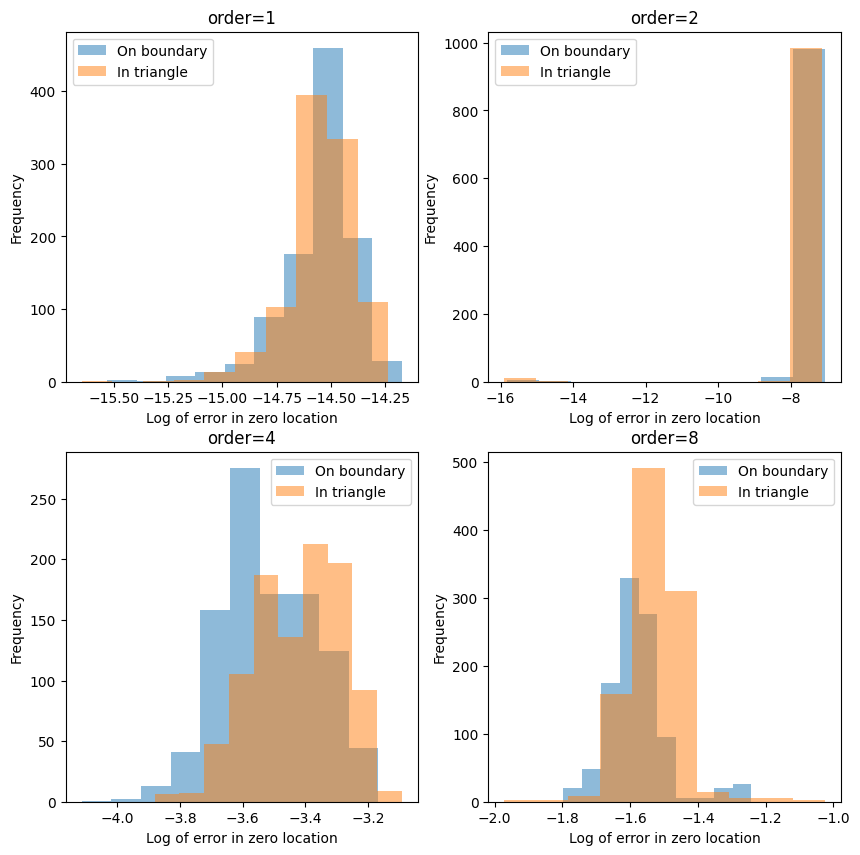

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(np.log10(np.asarray(on_pole_error[i]) + 1e-16), alpha=0.5, label="On boundary")
    ax.hist(np.log10(np.asarray(in_pole_error[i]) + 1e-16), alpha=0.5, label="In triangle")
    ax.set_xlabel("Log of error in zero location")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()

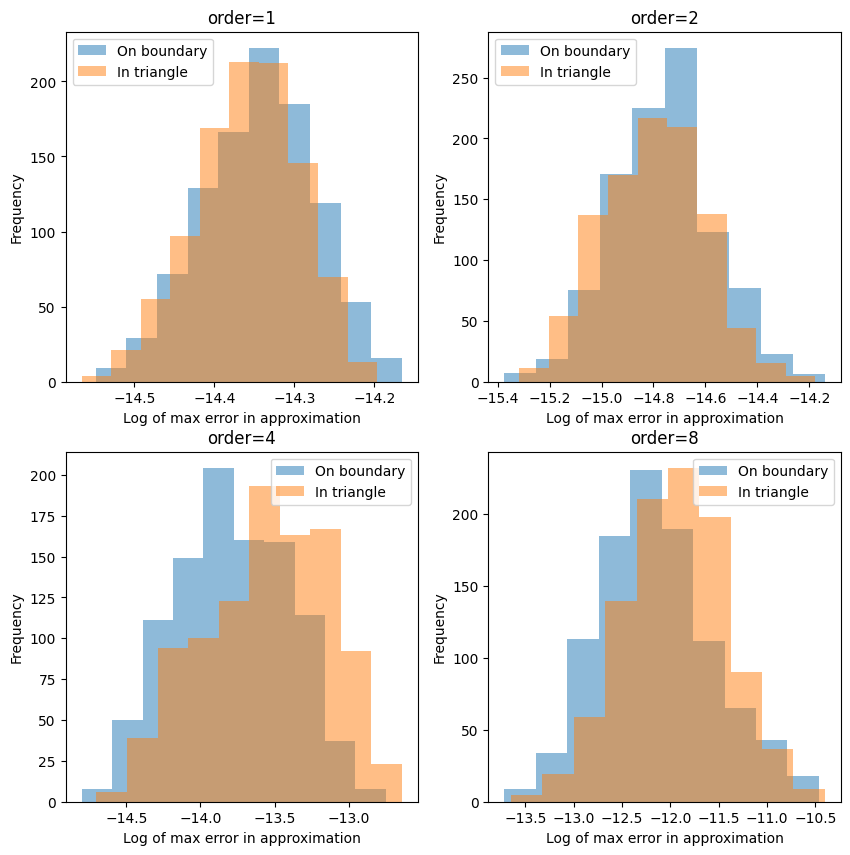

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(np.log10(on_approximation_error[i]), alpha=0.5, label="On boundary")
    ax.hist(np.log10(in_approximation_error[i]), alpha=0.5, label="In triangle")
    ax.set_xlabel("Log of max error in approximation")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()